In [5]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np
import scipy.stats as stats

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [23]:
data = pd.read_csv("winequality-red.csv", sep=';')
data = data[data['total sulfur dioxide']<200]

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

data['boolQuality'] = 0
for i in range(len(data)):
    if data.iloc[i,-2] > 5:
        data.iloc[i,-1] = 1

In [27]:
dataT = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:, None]

In [28]:
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size= 0.2)

train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# train and test dataloaders
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle = True)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, drop_last = True)

In [36]:
class ANNwine_withBNorm(nn.Module):
    def __init__(self):
        super().__init__()

        # input layer
        self.input = nn.Linear(11,16)

        ### hidden layers 
        self.fc1 = nn.Linear(16,32)
        self.bnorm1 = nn.BatchNorm1d(16)
        self.fc2 = nn.Linear(32,20)
        self.bnorm2 = nn.BatchNorm1d(32)

        # output layer
        self.output = nn.Linear(20,1)

    def forward(self,x,doBN):
        x = F.relu(self.input(x))

        if doBN:
            # hidden layer 1
            x = self.bnorm1(x)
            x = self.fc1(x)
            x = F.relu(x)

            # hidden layer 2
            x = self.bnorm2(x)
            x = self.fc2(x)
            x = F.relu(x)
        
        else:
            # hidden layer 1
            x = F.relu(self.fc1(x))

            # hidden layer 2
            x = F.relu(self.fc2(x))
        
        return self.output(x)






In [39]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel(doBN=True):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  losses   = torch.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X,doBN)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)



    ### test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X,doBN)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

In [40]:

# train a model NO BATCHNORM
winenet = ANNwine_withBNorm()
trainAccNo,testAccNo,lossesNo = trainTheModel(False)

# train a model WITH BATCHNORM
winenet = ANNwine_withBNorm()
trainAccWith,testAccWith,lossesWith = trainTheModel(True)


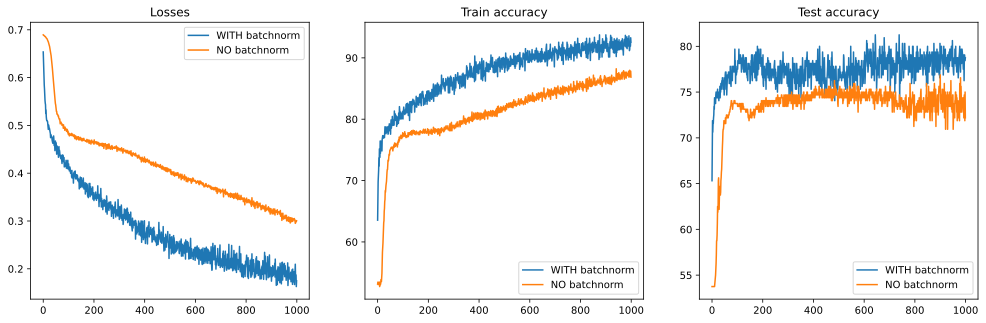

In [41]:
# plot the results
fig,ax = plt.subplots(1,3,figsize=(17,5))

ax[0].plot(lossesWith,label='WITH batchnorm')
ax[0].plot(lossesNo,label='NO batchnorm')
ax[0].set_title('Losses')
ax[0].legend()

ax[1].plot(trainAccWith,label='WITH batchnorm')
ax[1].plot(trainAccNo,label='NO batchnorm')
ax[1].set_title('Train accuracy')
ax[1].legend()

ax[2].plot(testAccWith,label='WITH batchnorm')
ax[2].plot(testAccNo,label='NO batchnorm')
ax[2].set_title('Test accuracy')
ax[2].legend()

plt.show()